**Read in images**

In [ ]:
import zipfile
import os

zip_path = '/content/project1_dataset.zip'  # Replace with your zip file name
extract_dir = '/content/images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to {extract_dir}")

Extracted to /content/images


Loaded 400 images


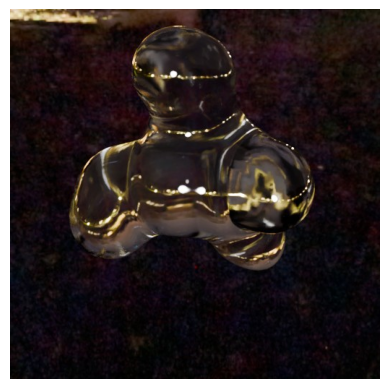

In [ ]:
import matplotlib.pyplot as plt
import cv2

images = []
labels = []

for subdir, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(subdir, file)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # BGR format
            if img is not None:
                images.append(img_rgb)
                label = os.path.basename(subdir)
                labels.append(label)

print(f"Loaded {len(images)} images")
plt.imshow(img_rgb,cmap = "gray")
plt.axis('off');

MAKE SURE IMAGES ARE THE SAME SIZE

In [ ]:

import numpy as np
valid_exts = ('.jpg', '.jpeg', '.png')
image_dir = "/content/images/project1_dataset"
image_paths = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(valid_exts):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} images")

Found 400 images


In [ ]:
import cv2
images = []
target_size = (512, 512)

for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        img_resized = cv2.resize(img, target_size)
        images.append(img_resized)

print(f"✅ Loaded {len(images)} images")

✅ Loaded 400 images


NORMALIZE PIXEL IMAGES

In [ ]:
img_array = np.array(images)/255.0

In [ ]:
print(img_array.shape)
print(img_array[0])

(400, 512, 512, 3)
[[[0.78823529 0.70588235 0.64705882]
  [0.78823529 0.70588235 0.64705882]
  [0.78823529 0.70588235 0.64705882]
  ...
  [0.76470588 0.68627451 0.61960784]
  [0.76078431 0.68235294 0.61568627]
  [0.76078431 0.68235294 0.61568627]]

 [[0.78823529 0.70588235 0.64705882]
  [0.78823529 0.70588235 0.64705882]
  [0.78823529 0.70588235 0.64705882]
  ...
  [0.75686275 0.67843137 0.61176471]
  [0.75686275 0.67843137 0.61176471]
  [0.75294118 0.6745098  0.60784314]]

 [[0.78823529 0.70588235 0.64705882]
  [0.78823529 0.70588235 0.64705882]
  [0.78823529 0.70588235 0.64705882]
  ...
  [0.75686275 0.67843137 0.61176471]
  [0.75686275 0.67843137 0.61176471]
  [0.75294118 0.6745098  0.60784314]]

 ...

 [[0.28235294 0.28235294 0.25882353]
  [0.28627451 0.28627451 0.2627451 ]
  [0.29803922 0.29803922 0.2745098 ]
  ...
  [0.14901961 0.25882353 0.25882353]
  [0.1372549  0.25490196 0.25882353]
  [0.12941176 0.24705882 0.25098039]]

 [[0.2627451  0.25882353 0.24313725]
  [0.27058824 0.26

FLATTEN INTO A 1-D ARRAY

In [ ]:
flattened_images = np.array([img.flatten() for img in images])

 # shape: (num_images, H*W*3)
flattened_images.shape

(400, 786432)

DETERMINE OPTIMAL # OF PCA COMPONENTS USING explained variance plot

In [ ]:

root = "/content/images/project1_dataset"  # top-level folder
valid_ext = ('.jpg', '.jpeg', '.png')

# Recursively gather image paths from all subfolders
image_paths = [
    os.path.join(dirpath, filename)
    for dirpath, _, filenames in os.walk(root)
    for filename in filenames
    if filename.lower().endswith(valid_ext)
]

print(f"Found {len(image_paths)} images (including subfolders)")

Found 400 images (including subfolders)


In [ ]:
def batch_generator(paths, batch_size=32, target_size=(128, 128)):
    """Yield batches of flattened, normalized images."""
    for i in range(0, len(paths), batch_size):
        batch_imgs = []
        for p in paths[i:i+batch_size]:
            img = cv2.imread(p)
            if img is None:                     # skip unreadable files
                continue
            img = cv2.resize(img, target_size)
            img = img.astype("float32") / 255.0
            batch_imgs.append(img.flatten())    # 1‑D vector

        if batch_imgs:                          # only yield if not empty
            yield np.vstack(batch_imgs)

In [ ]:
from sklearn.decomposition import PCA

X = flattened_images.copy()

n_sample = 250  # You can go lower (e.g. 500) if RAM is tight
idx = np.random.choice(X.shape[0], size=n_sample, replace=False)
X_sample = X[idx]

# Run PCA on this sample
pca = PCA().fit(X_sample)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


✔  104 components retain ≈95 % variance


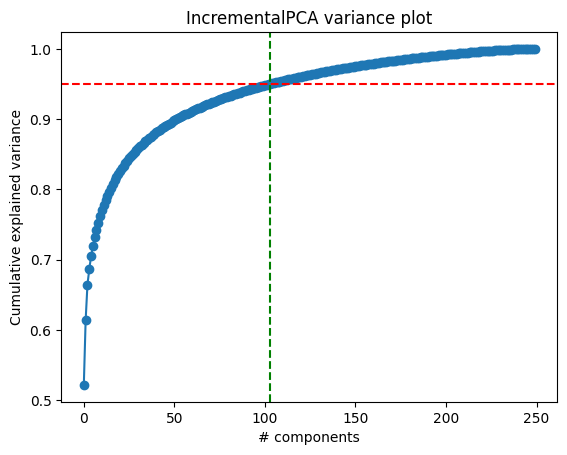

In [ ]:
import matplotlib.pyplot as plt

cum_var = np.cumsum(pca.explained_variance_ratio_)
optimal_k = np.argmax(cum_var >= 0.95) + 1     # +1 to convert index→count

print(f"✔  {optimal_k} components retain ≈95 % variance")

# (optional) scree plot
plt.plot(cum_var, marker='o')
plt.axhline(0.95, color='r', ls='--')
plt.axvline(optimal_k-1, color='g', ls='--')
plt.xlabel("# components")
plt.ylabel("Cumulative explained variance")
plt.title("IncrementalPCA variance plot")
plt.show()

APPLY PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA

batch_size = optimal_k  # Try 25–100 based on your RAM
pca = IncrementalPCA(n_components=optimal_k)

for i in range(0, len(X), batch_size):
    X_batch = X[i:i+batch_size]
    pca.partial_fit(X_batch)
X_pca = []
for i in range(0, len(X), batch_size):
    X_batch = X[i:i+batch_size]
    X_pca.append(pca.transform(X_batch))

X_pca = np.vstack(X_pca)


In [ ]:
#USE UMAP FOR VISUALIZATION, DISPLAY SCATTERPLOT WITH EACH MATERIAL AS A DIFFERENT COLOR TO ILLUSTRATE CLUSTERING

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_pca)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


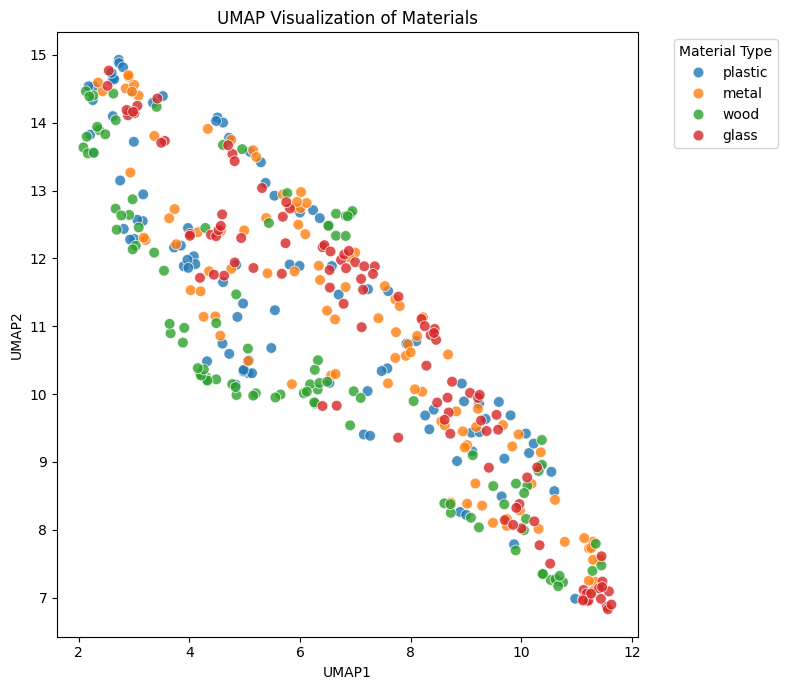

In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for easy plotting
df_umap = pd.DataFrame({
    'UMAP1': X_umap[:, 0],
    'UMAP2': X_umap[:, 1],
    'Material': labels  # This should match the number of samples
})

plt.figure(figsize=(8, 7))
sns.scatterplot(
    data=df_umap,
    x='UMAP1',
    y='UMAP2',
    hue='Material',
    palette='tab10',
    s=60,
    alpha=0.8
)
plt.title('UMAP Visualization of Materials')
plt.legend(title='Material Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()











SPLIT DATA INTO TESTING AND TRAINING

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_pca, labels, test_size=0.2, random_state=42, stratify=labels
)



Choosing Optimal K Value

k=3, Accuracy=0.3025
k=5, Accuracy=0.2725
k=10, Accuracy=0.2525
k=15, Accuracy=0.2500
k=20, Accuracy=0.2525
k=25, Accuracy=0.2500
k=30, Accuracy=0.2500


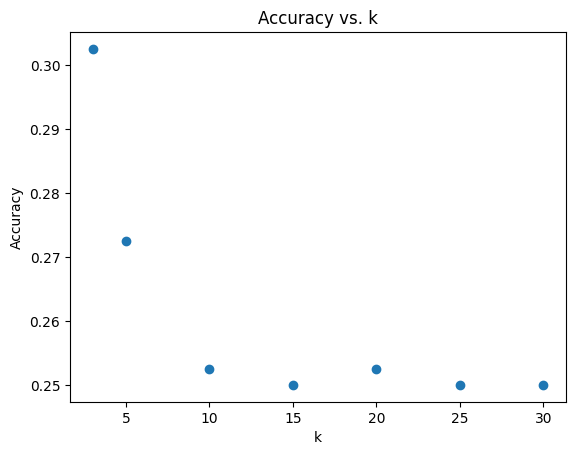

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # Import matplotlib


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)
k_values = [3, 5, 10, 15, 20, 25, 30]
mean_scores = [] # List to store mean scores

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled,labels, cv=5)
    mean_scores.append(scores.mean()) # Append the mean score
    print(f"k={k}, Accuracy={scores.mean():.4f}")

# Plot after the loop
plt.scatter(k_values, mean_scores) # Use mean_scores for plotting
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. k")
plt.show() # Show the plot

IMPLEMENT KNN FROM SKLEARN AND FIT

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

ACCURACY SCORE

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = knn.predict(X_test)

# Compare predictions to true labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4125


CONFUSION MATRIX

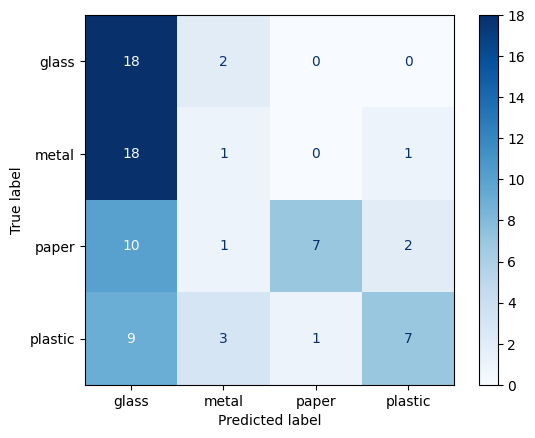

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
label = ["glass","metal","paper","plastic"]
# After training and predicting:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap='Blues')
plt.show()